In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dask.dataframe as dd

from sklearn.linear_model import LogisticRegression
from scipy.signal import find_peaks, peak_widths

import plotly.express as px
import plotly.graph_objects as go

In [3]:
# Constants
INPUT_DATA_PATH = r"../../data/dataset_train.csv"

# Metro in Porto, Portugal


|     Column      | Variable type |
|-----------------|---------------|
| timestamp       | continuous    |
| TP2             | continuous    |
| TP3             | continuous    |
| H1              | continuous    |
| DV_pressure     | continuous    |
| Reservoirs      | continuous    |
| Oil_temperature | continuous    |
| Flowmeter       | continuous    |
| Motor_current   | continuous    |
| COMP            | categorical   |
| DV_eletric      | categorical   |
| Towers          | categorical   |
| MPG             | categorical   |
| LPS             | categorical   |
| Pressure_switch | categorical   |
| Oil_level       | categorical   |
| Caudal_impulses | categorical   |
| gpsLong         | continuous    |
| gpsLat          | continuous    |
| gpsSpeed        | continuous    |
| gpsQuality      | categorical   |


References:
- [data](https://zenodo.org/record/6854240#.YvuPmHZBzBV)
- [paper](https://arxiv.org/pdf/2207.05466.pdf#view=fitH&toolbar=1)

Columns:

ANALOGUE SIGNALS
 - `TP2` - compressor pressure
 - `TP3` - pneumatic panel pressure
 - `H1` - valve?
 - `DV_pressure` - pressure drop?
 - `Reservoirs` - ?
 - `Oil_temperature` -  temperature of the oil present on the compressor
 - `Flowmeter` - ?
 - `Motor_current` - motor current; 0 A when compressor is off, 4A when compressor is working offloaded, 7A when compressor is under load
 
DIGITAL SIGNALS

(only assume two values: zero when inactive or one when activated)
 - `COMP` -  air intake valve on the compressor; 1 = no admission of air on the compressor
 - `DV_eletric` - compressor outlet valve; 1 = compressor is under load
 - `Towers` - defines which tower is working; 0 = tower 1 is working
 - `MPG` -  intake valve to start the compressor under load
 - `LPS` - 1 = pressure < 7 bars
 - `Pressure_switch` - ?
 - `Oil_level` - 1 = oil is below expected level
 - `Caudal_impulses` - ?
 
 GPS DATA
 - `gpsLong` - longitude
 - `gpsLat` - latitude
 - `gpsSpeed` - speed of the train
 - `gpsQuality` - 1 = (guess) missing

Failures:

| No   |   Type      | Component   |     Start      |      End       |
|------|-------------|-------------|----------------|----------------|
|    1 | Air  Leak   | Air Dryer   | 28-2-22 21:53  | 1-03-22 02:00  |
|    2 | Air  Leak   | Clients     | 23-3-22 14:54  | 23-03-22 15:24 |
|    3 | Oil  Leak   | Compressor  | 30-5-22 12:00  | 02-06-22 06:18 |

Data collected from January to June 2022.

Data points in total: 10979547.

### Estimate failure rows

In [4]:
failure_dates = pd.to_datetime([
    "28-2-22 21:53",
    "23-3-22 14:54",
    "30-5-22 12:00",
])

data_collection_start = pd.to_datetime("1-1-22 00:00")
data_collection_end = pd.to_datetime("30-6-22 23:59")

In [5]:
dates = pd.Series([
    data_collection_start,
    *failure_dates,
    data_collection_end,
])

records = pd.DataFrame({
    "date": dates,
    "line_num": [0, np.NaN, np.NaN, np.NaN, 10979547]
})

In [6]:
time_differences = records.date - records.date[0]
elapsed_seconds = time_differences.apply(lambda x: x.total_seconds())
records["normalized_time"] = elapsed_seconds / elapsed_seconds[4]
records

date    line_num  normalized_time
0 2022-01-01 00:00:00         0.0         0.000000
1 2022-02-28 21:53:00         NaN         0.325481
2 2022-03-23 14:54:00         NaN         0.450946
3 2022-05-30 12:00:00         NaN         0.825970
4 2022-06-30 23:59:00  10979547.0         1.000000

In [7]:
def lerp(a, b, t):
    """Linear interpolation between `a` and `b`. `t` is between [0, 1]."""
    return a + (b - a) * t

a, b = records.line_num[0], records.line_num[4]

records.line_num = [np.int32(lerp(a, b, t)) for t in records.normalized_time]

In [8]:
records

date  line_num  normalized_time
0 2022-01-01 00:00:00         0         0.000000
1 2022-02-28 21:53:00   3573632         0.325481
2 2022-03-23 14:54:00   4951177         0.450946
3 2022-05-30 12:00:00   9068776         0.825970
4 2022-06-30 23:59:00  10979547         1.000000

In [9]:
# # Split the raw data to 10 parts

# df = dd.read_csv("../../dataset_train.csv")
# df = df.repartition(npartitions=10)
# df.to_csv("file_*.csv")

# reader = pd.read_csv("../../file_0.csv", chunksize=10_000)

In [11]:
# %timeit dd.read_csv("../../data/dataset_train.csv")

In [ ]:
# metro = dd.read_csv("../../data/dataset_train.csv")

In [ ]:
# metro.columns

In [ ]:
# %timeit pd.to_datetime(metro.timestamp, infer_datetime_format=True)

In [ ]:
# metro.divisions

In [12]:
# metro.partitions[1]

## Pandas

### Read chunks

In [6]:
# reader = pd.read_csv(INPUT_DATA_PATH, chunksize=1_000_000)

In [11]:
metro = pd.read_csv(INPUT_DATA_PATH)  # 40 sec

### Read part of the data

In [4]:
column_names = pd.read_csv(INPUT_DATA_PATH, nrows=0).columns

metro = pd.read_csv(INPUT_DATA_PATH, skiprows = 500_000, nrows = 200_000, header=None)

metro.columns = column_names

### Get to know
Observations:
- no missing data
- categorical variables: 

In [12]:
metro.shape

(10979546, 21)

In [13]:
print("\n".join(metro.columns))

timestamp
TP2
TP3
H1
DV_pressure
Reservoirs
Oil_temperature
Flowmeter
Motor_current
COMP
DV_eletric
Towers
MPG
LPS
Pressure_switch
Oil_level
Caudal_impulses
gpsLong
gpsLat
gpsSpeed
gpsQuality


In [14]:
metro.head()

timestamp    TP2    TP3     H1  DV_pressure  Reservoirs  \
0  2022-01-01 06:00:00 -0.012  9.758  9.760       -0.028       1.576   
1  2022-01-01 06:00:01 -0.012  9.760  9.760       -0.028       1.578   
2  2022-01-01 06:00:02 -0.010  9.760  9.760       -0.028       1.578   
3  2022-01-01 06:00:03 -0.012  9.756  9.756       -0.030       1.576   
4  2022-01-01 06:00:04 -0.012  9.756  9.756       -0.030       1.578   

   Oil_temperature  Flowmeter  Motor_current  COMP  ...  Towers  MPG  LPS  \
0           63.350  19.049625         3.9550     1  ...       1    1    0   
1           63.250  19.049625         4.0275     1  ...       1    1    0   
2           63.325  19.040281         3.9450     1  ...       1    1    0   
3           63.200  19.040281         3.9300     1  ...       1    1    0   
4           63.150  19.049625         3.9950     1  ...       1    1    0   

   Pressure_switch  Oil_level  Caudal_impulses  gpsLong   gpsLat  gpsSpeed  \
0                0          0                0 -8.65934  41.2124         0   
1                0          0                0 -8.65934  41.2124         0   
2                0          0                0 -8.65934  41.2124         0   
3                0          0                0 -8.65934  41.2124         0   
4                0          0                0 -8.65934  41.2124         0   

   gpsQuality  
0           1  
1           1  
2           1  
3           1  
4           1  

[5 rows x 21 columns]

In [15]:
metro.dtypes

timestamp           object
TP2                float64
TP3                float64
H1                 float64
DV_pressure        float64
Reservoirs         float64
Oil_temperature    float64
Flowmeter          float64
Motor_current      float64
COMP                 int64
DV_eletric           int64
Towers               int64
MPG                  int64
LPS                  int64
Pressure_switch      int64
Oil_level            int64
Caudal_impulses      int64
gpsLong            float64
gpsLat             float64
gpsSpeed             int64
gpsQuality           int64
dtype: object

In [16]:
metro.describe(include="all").T

count    unique                  top freq       mean  \
timestamp          10979546  10979546  2022-01-01 06:00:00    1        NaN   
TP2              10979546.0       NaN                  NaN  NaN   1.118317   
TP3              10979546.0       NaN                  NaN  NaN   8.931651   
H1               10979546.0       NaN                  NaN  NaN    7.73087   
DV_pressure      10979546.0       NaN                  NaN  NaN  -0.038257   
Reservoirs       10979546.0       NaN                  NaN  NaN   1.546639   
Oil_temperature  10979546.0       NaN                  NaN  NaN   66.92224   
Flowmeter        10979546.0       NaN                  NaN  NaN  20.306993   
Motor_current    10979546.0       NaN                  NaN  NaN   2.336845   
COMP             10979546.0       NaN                  NaN  NaN   0.868885   
DV_eletric       10979546.0       NaN                  NaN  NaN   0.127754   
Towers           10979546.0       NaN                  NaN  NaN   0.932585   
MPG              10979546.0       NaN                  NaN  NaN   0.868884   
LPS              10979546.0       NaN                  NaN  NaN   0.006164   
Pressure_switch  10979546.0       NaN                  NaN  NaN        0.0   
Oil_level        10979546.0       NaN                  NaN  NaN        0.0   
Caudal_impulses  10979546.0       NaN                  NaN  NaN   0.001461   
gpsLong          10979546.0       NaN                  NaN  NaN  -4.446051   
gpsLat           10979546.0       NaN                  NaN  NaN  21.204932   
gpsSpeed         10979546.0       NaN                  NaN  NaN   5.025135   
gpsQuality       10979546.0       NaN                  NaN  NaN    0.51481   

                       std      min       25%        50%        75%        max  
timestamp              NaN      NaN       NaN        NaN        NaN        NaN  
TP2               3.066012     -4.0    -0.008     -0.008     -0.006    22.3096  
TP3               1.026502     -4.0     8.486       8.99      9.484     10.408  
H1                3.104537     -4.0     8.236      8.758       9.28     10.414  
DV_pressure       0.274426     -4.0    -0.032     -0.028     -0.026      8.326  
Reservoirs        0.336291     -4.0      1.47      1.592      1.638      2.054  
Oil_temperature   8.653277    -50.0      63.7      68.25      71.05       97.9  
Flowmeter         3.891984     0.25  19.01225  19.040281  19.255188  43.072406  
Motor_current     2.230631     -5.0    0.0025     3.7025      3.835      9.685  
COMP              0.337526      0.0       1.0        1.0        1.0        1.0  
DV_eletric        0.333815      0.0       0.0        0.0        0.0        1.0  
Towers            0.250739      0.0       1.0        1.0        1.0        1.0  
MPG               0.337527      0.0       1.0        1.0        1.0        1.0  
LPS               0.078267      0.0       0.0        0.0        0.0        1.0  
Pressure_switch        0.0      0.0       0.0        0.0        0.0        0.0  
Oil_level         0.000523      0.0       0.0        0.0        0.0        1.0  
Caudal_impulses   0.038197      0.0       0.0        0.0        0.0        1.0  
gpsLong           4.316384 -9.13004  -8.65891   -8.54272        0.0        0.0  
gpsLat             20.5859      0.0       0.0    41.1546    41.1882     41.949  
gpsSpeed         11.631586      0.0       0.0        0.0        0.0      323.0  
gpsQuality        0.499781      0.0       0.0        1.0        1.0        1.0

In [17]:
metro.isna().any()

timestamp          False
TP2                False
TP3                False
H1                 False
DV_pressure        False
Reservoirs         False
Oil_temperature    False
Flowmeter          False
Motor_current      False
COMP               False
DV_eletric         False
Towers             False
MPG                False
LPS                False
Pressure_switch    False
Oil_level          False
Caudal_impulses    False
gpsLong            False
gpsLat             False
gpsSpeed           False
gpsQuality         False
dtype: bool

In [22]:
list(metro.columns)

['timestamp',
 'TP2',
 'TP3',
 'H1',
 'DV_pressure',
 'Reservoirs',
 'Oil_temperature',
 'Flowmeter',
 'Motor_current',
 'COMP',
 'DV_eletric',
 'Towers',
 'MPG',
 'LPS',
 'Pressure_switch',
 'Oil_level',
 'Caudal_impulses',
 'gpsLong',
 'gpsLat',
 'gpsSpeed',
 'gpsQuality']

### Format columns

#### Filter (feature selection)

#### Rename TODO

#### Set index

In [18]:
metro.index = pd.to_datetime(metro.timestamp)
metro = metro.drop(columns = 'timestamp')
metro.index.dtype

dtype('<M8[ns]')

In [19]:
metro.index[0], metro.index[-1]

(Timestamp('2022-01-01 06:00:00'), Timestamp('2022-06-02 15:49:53'))

### Examine, identify patterns

#### Single day

In [41]:
metro[:1000].index.hour

Int64Index([6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
            ...
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
           dtype='int64', name='timestamp', length=1000)

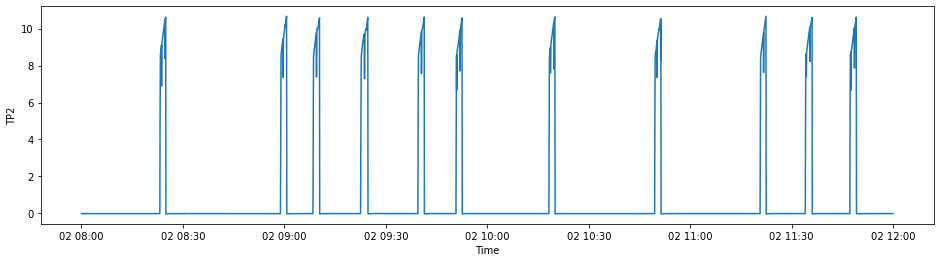

In [50]:
query_str = "('2022-01-02 08:00' < timestamp) & (timestamp < '2022-01-02 12:00')"

plt.figure(figsize = (16, 4))
plt.plot(metro.query(query_str).TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

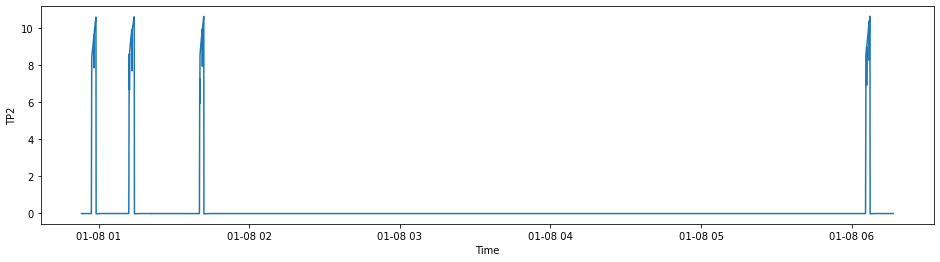

In [26]:
plt.figure(figsize = (16, 4))
plt.plot(metro[:5000].TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

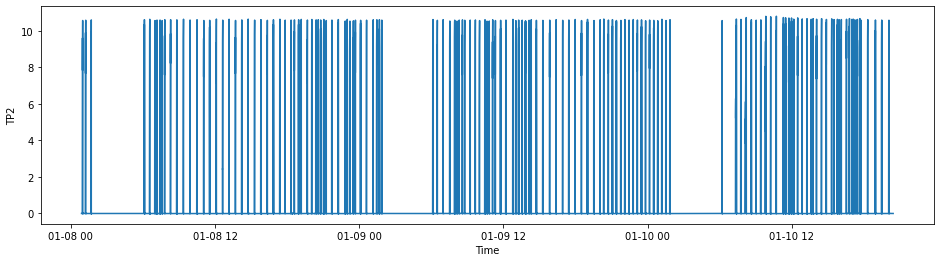

In [27]:
plt.figure(figsize = (16, 4))
plt.plot(metro.TP2)
plt.xlabel("Time")
plt.ylabel("TP2")
plt.show()

#### single day

In [28]:
data_from_single_day = metro[metro.index.day == 2]

In [29]:
data_from_single_day

Empty DataFrame
Columns: [TP2, TP3, H1, DV_pressure, Reservoirs, Oil_temperature, Flowmeter, Motor_current, COMP, DV_eletric, Towers, MPG, LPS, Pressure_switch, Oil_level, Caudal_impulses, gpsLong, gpsLat, gpsSpeed, gpsQuality]
Index: []

#### third failure

In [30]:
third_failure = pd.read_csv("../../data/dataset_train.csv", skiprows = 10_700_000, nrows = 200_000)

In [31]:
third_failure.columns = ['timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']

In [32]:
third_failure.shape

(200000, 21)

In [33]:
third_failure.index = pd.to_datetime(third_failure.timestamp)
third_failure = third_failure.drop(columns = 'timestamp')
third_failure.index.dtype

dtype('<M8[ns]')

The last and the first date in the interval. Third failure occurred on `2022-05-30 12:00:00`.

In [34]:
third_failure.index[0], third_failure.index[-1]

(Timestamp('2022-05-29 18:10:52'), Timestamp('2022-06-01 13:44:08'))

In [35]:
day_of_failure = third_failure[third_failure.index.day == 30]

In [36]:
day_of_failure.head(2)

TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                           
2022-05-30 00:00:00 -0.014  9.818  9.290       -0.032       1.464   
2022-05-30 00:00:01 -0.012  9.816  9.288       -0.032       1.464   

                     Oil_temperature  Flowmeter  Motor_current  COMP  \
timestamp                                                              
2022-05-30 00:00:00           68.625  19.367313         3.8225     1   
2022-05-30 00:00:01           68.525  19.367313         3.7975     1   

                     DV_eletric  Towers  MPG  LPS  Pressure_switch  Oil_level  \
timestamp                                                                       
2022-05-30 00:00:00           0       1    1    0                0          0   
2022-05-30 00:00:01           0       1    1    0                0          0   

                     Caudal_impulses  gpsLong  gpsLat  gpsSpeed  gpsQuality  
timestamp                                                                    
2022-05-30 00:00:00                0      0.0     0.0         0           0  
2022-05-30 00:00:01                0      0.0     0.0         0           0

In [37]:
lunch_time = day_of_failure[(11 <= day_of_failure.index.hour) & (day_of_failure.index.hour <= 13)]

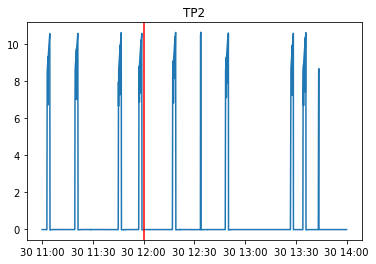

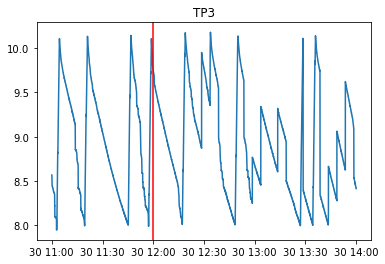

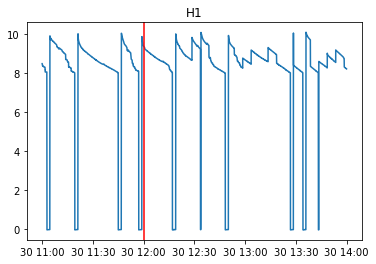

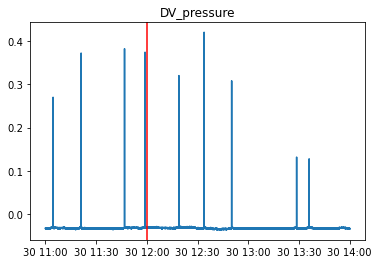

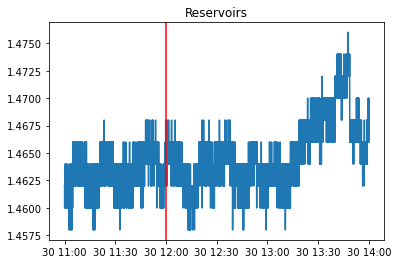

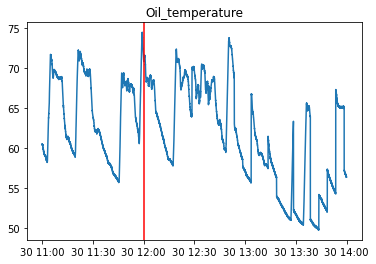

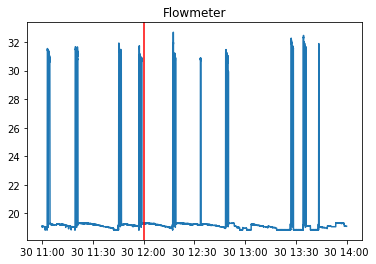

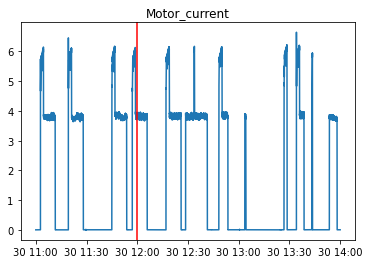

In [38]:
def plot_variable(df, var, vline):
    plt.plot(df[var])
    plt.title(var)
    plt.axvline(vline, c='red')
    plt.show()

columns_with_continous_variables = ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current',]

for c in columns_with_continous_variables:
    plot_variable(lunch_time, c, pd.to_datetime("2022-05-30 12:00:00"))

#### train speed on its route

In [39]:
speed_to_plot = metro[["gpsLong", "gpsLat", "gpsSpeed", "gpsQuality"]]
speed_to_plot = speed_to_plot[speed_to_plot.index.hour.isin([10, 11])]
speed_to_plot = speed_to_plot[speed_to_plot.gpsQuality == 1]

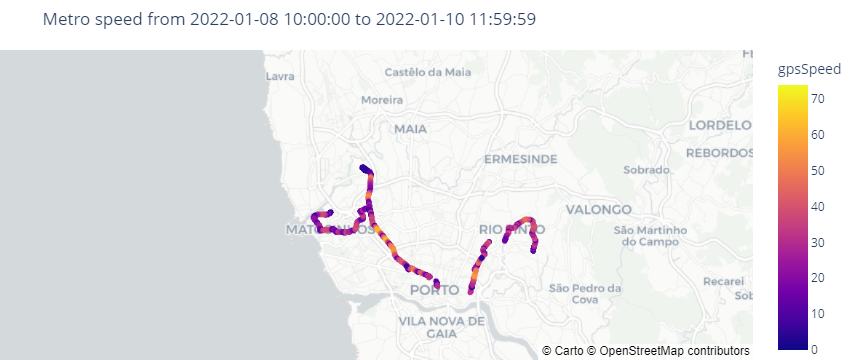

In [40]:
title = f"Metro speed from {speed_to_plot.index[0]} to {speed_to_plot.index[-1]}"

fig = px.scatter_mapbox(speed_to_plot, lat="gpsLat", lon="gpsLong", color = "gpsSpeed", zoom=10, title=title)

fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

In [41]:
speed_to_plot_2 = speed_to_plot[:]

In [42]:
speed_to_plot_2.gpsLong = speed_to_plot_2.gpsLong.round(3)
speed_to_plot_2.gpsLat = speed_to_plot_2.gpsLat.round(3)

In [43]:
mean_speed = pd.DataFrame(speed_to_plot_2.groupby(["gpsLong", "gpsLat"]).gpsSpeed.mean())

In [44]:
mean_speed = mean_speed.reset_index()

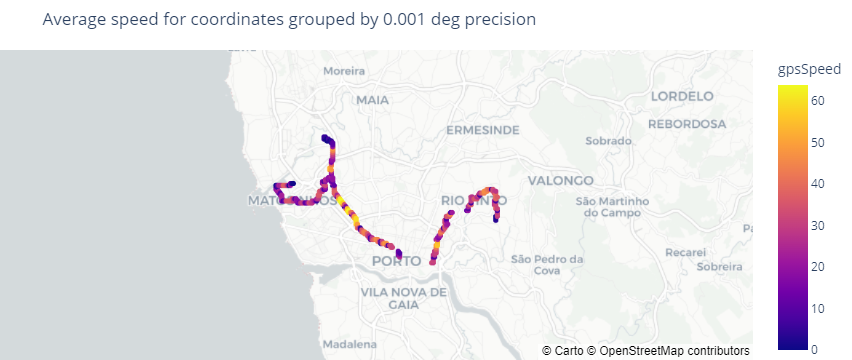

In [45]:
title = f"Average speed for coordinates grouped by 0.001 deg precision"

fig = px.scatter_mapbox(mean_speed, lat="gpsLat", lon="gpsLong", hover_data=["gpsSpeed"], color = "gpsSpeed", zoom=10, title=title)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()

### Detect peaks

#### Test the concept

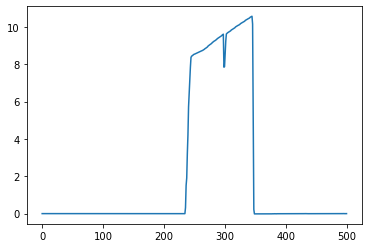

In [46]:
x = metro.TP2[:500]
plt.plot(np.arange(len(x)), x)
plt.show()

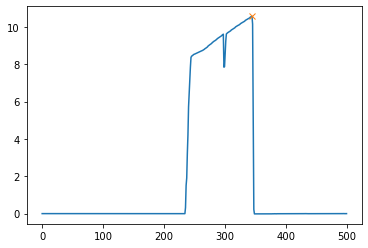

In [47]:
peaks, _ = find_peaks(x, height=8, distance=100)
plt.plot(np.arange(len(x)), x)
plt.plot(peaks, x[peaks], "x")
plt.show()

#### Go further

In [48]:
x = metro.TP2[:10000]
x = x.reset_index(drop=True)
x

0      -0.006
1      -0.006
2      -0.006
3      -0.006
4      -0.006
        ...  
9995   -0.006
9996   -0.006
9997   -0.008
9998   -0.006
9999   -0.008
Name: TP2, Length: 10000, dtype: float64

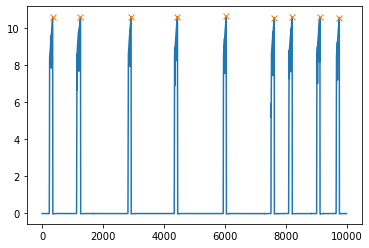

In [49]:
peaks, _ = find_peaks(x, height=10, distance=100)
plt.plot(np.arange(len(x)), x)
plt.plot(peaks, x[peaks], "x")
plt.show()

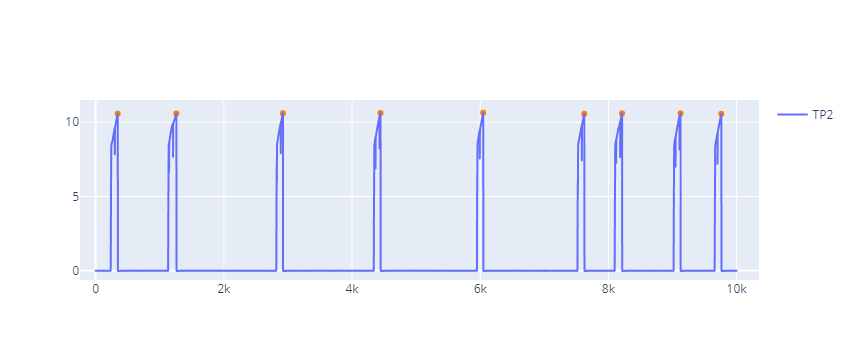

In [50]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

#### Plot widths
`peak_widths` returns a `tuple(width, y, x_start, x_end)`

In [51]:
widths = peak_widths(x, peaks, rel_height=0.95)
widths 

(array([111.76330365, 131.10383976, 104.42486525, 107.50153724,
         99.88700248, 108.64691291, 117.19616835, 109.52048391,
        106.37824939]),
 array([0.5191, 0.5085, 0.5074, 0.5081, 0.5072, 0.5056, 0.507 , 0.5071,
        0.5075]),
 array([ 235.1726431 , 1130.75813609, 2818.70991736, 4339.26973214,
        5949.08849421, 7517.24154863, 8097.71568627, 9017.16402936,
        9657.56761364]),
 array([ 346.93594675, 1261.86197586, 2923.13478261, 4446.77126938,
        6048.97549669, 7625.88846154, 8214.91185462, 9126.68451327,
        9763.94586302]))

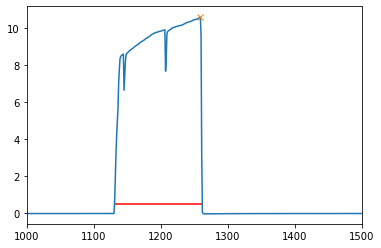

In [52]:
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.hlines(y = widths[1], xmin = widths[2], xmax = widths[3], color="red")
plt.xlim((1000, 1500))
plt.show()

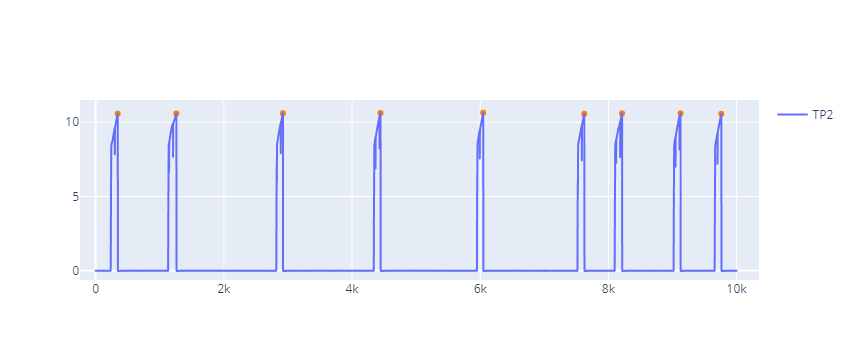

In [53]:
fig1 = px.line(x)
fig2 = px.scatter(x = peaks, y = x[peaks], color_discrete_sequence=['#ff7f0e'])
fig3 = go.Figure(data=fig1.data + fig2.data)
fig3.show()

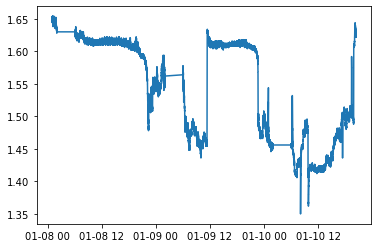

In [54]:
plt.plot(metro.Reservoirs)
plt.show()

In [92]:
metro

TP2    TP3     H1  DV_pressure  Reservoirs  \
timestamp                                                           
2022-01-08 00:53:13 -0.006  8.766  8.772       -0.028       1.652   
2022-01-08 00:53:14 -0.006  8.764  8.772       -0.026       1.652   
2022-01-08 00:53:15 -0.006  8.764  8.770       -0.026       1.650   
2022-01-08 00:53:16 -0.006  8.762  8.770       -0.028       1.650   
2022-01-08 00:53:17 -0.006  8.764  8.770       -0.028       1.652   
...                    ...    ...    ...          ...         ...   
2022-01-10 20:26:25 -0.006  8.704  8.716       -0.026       1.622   
2022-01-10 20:26:26 -0.006  8.704  8.716       -0.024       1.622   
2022-01-10 20:26:27 -0.006  8.702  8.716       -0.026       1.622   
2022-01-10 20:26:28 -0.006  8.702  8.714       -0.026       1.622   
2022-01-10 20:26:29 -0.006  8.700  8.714       -0.026       1.622   

                     Oil_temperature  Flowmeter  Motor_current  COMP  \
timestamp                                                              
2022-01-08 00:53:13           66.400  19.012250         0.0025     1   
2022-01-08 00:53:14           66.325  19.012250         0.0000     1   
2022-01-08 00:53:15           66.375  19.002906         0.0025     1   
2022-01-08 00:53:16           66.350  19.002906         0.0025     1   
2022-01-08 00:53:17           66.375  19.002906         0.0000     1   
...                              ...        ...            ...   ...   
2022-01-10 20:26:25           62.500  18.844062         0.0000     1   
2022-01-10 20:26:26           62.550  18.844062        -0.0025     1   
2022-01-10 20:26:27           62.500  18.844062         0.0000     1   
2022-01-10 20:26:28           62.400  18.844062         0.0000     1   
2022-01-10 20:26:29           62.400  18.844062         0.0000     1   

                     DV_eletric  Towers  MPG  LPS  Pressure_switch  Oil_level  \
timestamp                                                                       
2022-01-08 00:53:13           0       1    1    0                0          0   
2022-01-08 00:53:14           0       1    1    0                0          0   
2022-01-08 00:53:15           0       1    1    0                0          0   
2022-01-08 00:53:16           0       1    1    0                0          0   
2022-01-08 00:53:17           0       1    1    0                0          0   
...                         ...     ...  ...  ...              ...        ...   
2022-01-10 20:26:25           0       1    1    0                0          0   
2022-01-10 20:26:26           0       1    1    0                0          0   
2022-01-10 20:26:27           0       1    1    0                0          0   
2022-01-10 20:26:28           0       1    1    0                0          0   
2022-01-10 20:26:29           0       1    1    0                0          0   

                     Caudal_impulses  gpsLong   gpsLat  gpsSpeed  gpsQuality  
timestamp                                                                     
2022-01-08 00:53:13                0 -8.61664  41.1570         0           1  
2022-01-08 00:53:14                0 -8.61664  41.1570         0           1  
2022-01-08 00:53:15                0 -8.61664  41.1570         0           1  
2022-01-08 00:53:16                0 -8.61664  41.1570         0           1  
2022-01-08 00:53:17                0 -8.61664  41.1570         0           1  
...                              ...      ...      ...       ...         ...  
2022-01-10 20:26:25                0 -8.65959  41.2136         0           1  
2022-01-10 20:26:26                0 -8.65959  41.2136         0           1  
2022-01-10 20:26:27                0 -8.65959  41.2136         0           1  
2022-01-10 20:26:28                0 -8.65959  41.2136         0           1  
2022-01-10 20:26:29                0 -8.65959  41.2136         0           1  

[200000 rows x 20 columns]

### TODO compare diff days for same location / train stop